In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-20 00:52:35.468408
thunder  Fri Dec 20 00:52:35 2019
[0] GeForce GTX 1080 Ti | 41'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 48'C,   1 % | 10895 / 11178 MB | patra(10885M)
[2] GeForce GTX 1080 Ti | 26'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[3] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |   213 / 11178 MB | srikanth(203M)
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Fri Dec 20 00:52:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   41C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 34%   49C    P2    82W / 250W |  10895Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [17]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [18]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [19]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200
50/50 [==============================] - 24s 489ms/step - loss: 0.7100 - Accuracy: 0.5856 - Precision: 0.6008 - Recall: 0.5773 - F1: 0.5732 - AUC: 0.6205 - val_loss: 0.9881 - val_Accuracy: 0.2281 - val_Precision: 0.0390 - val_Recall: 0.7000 - val_F1: 0.0735 - val_AUC: 0.7184
Epoch 2/200
50/50 [==============================] - 22s 435ms/step - loss: 0.6669 - Accuracy: 0.6263 - Precision: 0.6318 - Recall: 0.6597 - F1: 0.6391 - AUC: 0.6660 - val_loss: 0.4107 - val_Accuracy: 0.8375 - val_Precision: 0.0694 - val_Recall: 0.1167 - val_F1: 0.0833 - val_AUC: 0.7013
Epoch 3/200
50/50 [==============================] - 23s 457ms/step - loss: 0.6661 - Accuracy: 0.6231 - Precision: 0.6346 - Recall: 0.6626 - F1: 0.6397 - AUC: 0.6623 - val_loss: 0.6491 - val_Accuracy: 0.7688 - val_Precision: 0.0600 - val_Recall: 0.1500 - val_F1: 0.0857 - val_AUC: 0.6192
Epoch 4/200
50/50 [==============================] - 22s 450ms/step - loss: 0.6461 - Accuracy: 0.6413 - Precision: 0.6383 - Recall: 0.68

Epoch 29/200
50/50 [==============================] - 22s 450ms/step - loss: 0.5568 - Accuracy: 0.7169 - Precision: 0.7237 - Recall: 0.7330 - F1: 0.7223 - AUC: 0.7870 - val_loss: 1.2491 - val_Accuracy: 0.1094 - val_Precision: 0.0235 - val_Recall: 0.6000 - val_F1: 0.0451 - val_AUC: 0.7830
Epoch 30/200
50/50 [==============================] - 23s 457ms/step - loss: 0.5424 - Accuracy: 0.7175 - Precision: 0.7047 - Recall: 0.7289 - F1: 0.7104 - AUC: 0.8012 - val_loss: 1.3252 - val_Accuracy: 0.1375 - val_Precision: 0.0281 - val_Recall: 0.6000 - val_F1: 0.0530 - val_AUC: 0.6931
Epoch 31/200
50/50 [==============================] - 22s 448ms/step - loss: 0.5750 - Accuracy: 0.7075 - Precision: 0.6916 - Recall: 0.7302 - F1: 0.7040 - AUC: 0.7674 - val_loss: 1.4031 - val_Accuracy: 0.1281 - val_Precision: 0.0176 - val_Recall: 0.5000 - val_F1: 0.0341 - val_AUC: 0.5175
Epoch 32/200
50/50 [==============================] - 23s 465ms/step - loss: 0.5543 - Accuracy: 0.7237 - Precision: 0.7130 - Recall: 

50/50 [==============================] - 22s 442ms/step - loss: 0.5337 - Accuracy: 0.7431 - Precision: 0.7389 - Recall: 0.7629 - F1: 0.7439 - AUC: 0.8124 - val_loss: 1.2731 - val_Accuracy: 0.0938 - val_Precision: 0.0231 - val_Recall: 0.5500 - val_F1: 0.0441 - val_AUC: 0.5310
Epoch 58/200
50/50 [==============================] - 22s 447ms/step - loss: 0.5572 - Accuracy: 0.7212 - Precision: 0.7268 - Recall: 0.7416 - F1: 0.7287 - AUC: 0.7886 - val_loss: 1.4035 - val_Accuracy: 0.1094 - val_Precision: 0.0277 - val_Recall: 0.6000 - val_F1: 0.0526 - val_AUC: 0.5984
Epoch 59/200
50/50 [==============================] - 23s 462ms/step - loss: 0.5479 - Accuracy: 0.7169 - Precision: 0.6968 - Recall: 0.7520 - F1: 0.7167 - AUC: 0.7961 - val_loss: 1.2719 - val_Accuracy: 0.1375 - val_Precision: 0.0225 - val_Recall: 0.4000 - val_F1: 0.0423 - val_AUC: 0.5695
Epoch 60/200
50/50 [==============================] - 22s 442ms/step - loss: 0.5539 - Accuracy: 0.7113 - Precision: 0.6965 - Recall: 0.7156 - F1: 

50/50 [==============================] - 23s 467ms/step - loss: 0.5493 - Accuracy: 0.7175 - Precision: 0.7090 - Recall: 0.7422 - F1: 0.7171 - AUC: 0.7925 - val_loss: 1.2296 - val_Accuracy: 0.1562 - val_Precision: 0.0248 - val_Recall: 0.5500 - val_F1: 0.0472 - val_AUC: 0.5413
Epoch 86/200
50/50 [==============================] - 22s 448ms/step - loss: 0.5311 - Accuracy: 0.7419 - Precision: 0.7496 - Recall: 0.7517 - F1: 0.7452 - AUC: 0.8147 - val_loss: 1.3010 - val_Accuracy: 0.1312 - val_Precision: 0.0207 - val_Recall: 0.6000 - val_F1: 0.0401 - val_AUC: 0.5348
Epoch 87/200
50/50 [==============================] - 22s 444ms/step - loss: 0.5250 - Accuracy: 0.7412 - Precision: 0.7269 - Recall: 0.7711 - F1: 0.7407 - AUC: 0.8178 - val_loss: 1.0733 - val_Accuracy: 0.1531 - val_Precision: 0.0288 - val_Recall: 0.6000 - val_F1: 0.0546 - val_AUC: 0.6399
Epoch 88/200
50/50 [==============================] - 23s 467ms/step - loss: 0.5422 - Accuracy: 0.7244 - Precision: 0.7034 - Recall: 0.7526 - F1: 

50/50 [==============================] - 22s 435ms/step - loss: 0.5412 - Accuracy: 0.7494 - Precision: 0.7442 - Recall: 0.7712 - F1: 0.7511 - AUC: 0.8030 - val_loss: 1.1221 - val_Accuracy: 0.1375 - val_Precision: 0.0203 - val_Recall: 0.4000 - val_F1: 0.0384 - val_AUC: 0.5581
Epoch 114/200
50/50 [==============================] - 22s 450ms/step - loss: 0.5569 - Accuracy: 0.7306 - Precision: 0.7260 - Recall: 0.7546 - F1: 0.7341 - AUC: 0.7897 - val_loss: 1.1899 - val_Accuracy: 0.1406 - val_Precision: 0.0038 - val_Recall: 0.1000 - val_F1: 0.0074 - val_AUC: 0.4013
Epoch 115/200
50/50 [==============================] - 23s 466ms/step - loss: 0.5471 - Accuracy: 0.7294 - Precision: 0.7348 - Recall: 0.7576 - F1: 0.7408 - AUC: 0.7969 - val_loss: 1.1811 - val_Accuracy: 0.1531 - val_Precision: 0.0308 - val_Recall: 0.5000 - val_F1: 0.0576 - val_AUC: 0.6624
Epoch 116/200
50/50 [==============================] - 22s 438ms/step - loss: 0.5248 - Accuracy: 0.7412 - Precision: 0.7286 - Recall: 0.7863 - F

50/50 [==============================] - 23s 466ms/step - loss: 0.5510 - Accuracy: 0.7200 - Precision: 0.7264 - Recall: 0.7333 - F1: 0.7247 - AUC: 0.7902 - val_loss: 1.1489 - val_Accuracy: 0.1250 - val_Precision: 0.0135 - val_Recall: 0.3000 - val_F1: 0.0257 - val_AUC: 0.5012
Epoch 142/200
50/50 [==============================] - 22s 444ms/step - loss: 0.5466 - Accuracy: 0.7312 - Precision: 0.7303 - Recall: 0.7544 - F1: 0.7359 - AUC: 0.7963 - val_loss: 1.2537 - val_Accuracy: 0.1656 - val_Precision: 0.0393 - val_Recall: 0.6000 - val_F1: 0.0724 - val_AUC: 0.5940
Epoch 143/200
50/50 [==============================] - 22s 445ms/step - loss: 0.5330 - Accuracy: 0.7500 - Precision: 0.7358 - Recall: 0.7782 - F1: 0.7503 - AUC: 0.8147 - val_loss: 1.1102 - val_Accuracy: 0.1531 - val_Precision: 0.0290 - val_Recall: 0.5500 - val_F1: 0.0548 - val_AUC: 0.6070
Epoch 144/200
50/50 [==============================] - 23s 467ms/step - loss: 0.5373 - Accuracy: 0.7194 - Precision: 0.7142 - Recall: 0.7496 - F

50/50 [==============================] - 22s 443ms/step - loss: 0.5247 - Accuracy: 0.7394 - Precision: 0.7110 - Recall: 0.7636 - F1: 0.7313 - AUC: 0.8215 - val_loss: 1.1608 - val_Accuracy: 0.1375 - val_Precision: 0.0104 - val_Recall: 0.3000 - val_F1: 0.0201 - val_AUC: 0.5538
Epoch 170/200
50/50 [==============================] - 23s 469ms/step - loss: 0.5213 - Accuracy: 0.7306 - Precision: 0.7268 - Recall: 0.7410 - F1: 0.7289 - AUC: 0.8197 - val_loss: 1.2366 - val_Accuracy: 0.1344 - val_Precision: 0.0177 - val_Recall: 0.5000 - val_F1: 0.0341 - val_AUC: 0.6133
Epoch 171/200
50/50 [==============================] - 22s 450ms/step - loss: 0.5341 - Accuracy: 0.7350 - Precision: 0.7205 - Recall: 0.7618 - F1: 0.7332 - AUC: 0.8099 - val_loss: 1.1829 - val_Accuracy: 0.1531 - val_Precision: 0.0146 - val_Recall: 0.4000 - val_F1: 0.0282 - val_AUC: 0.5158
Epoch 172/200
50/50 [==============================] - 22s 447ms/step - loss: 0.5332 - Accuracy: 0.7337 - Precision: 0.7105 - Recall: 0.7709 - F

50/50 [==============================] - 23s 467ms/step - loss: 0.5344 - Accuracy: 0.7287 - Precision: 0.7200 - Recall: 0.7486 - F1: 0.7244 - AUC: 0.8076 - val_loss: 1.3047 - val_Accuracy: 0.1750 - val_Precision: 0.0151 - val_Recall: 0.4000 - val_F1: 0.0292 - val_AUC: 0.4730
Epoch 198/200
50/50 [==============================] - 22s 439ms/step - loss: 0.5228 - Accuracy: 0.7437 - Precision: 0.7532 - Recall: 0.7617 - F1: 0.7520 - AUC: 0.8240 - val_loss: 1.1909 - val_Accuracy: 0.1906 - val_Precision: 0.0260 - val_Recall: 0.6000 - val_F1: 0.0497 - val_AUC: 0.4530
Epoch 199/200
50/50 [==============================] - 22s 437ms/step - loss: 0.5230 - Accuracy: 0.7500 - Precision: 0.7563 - Recall: 0.7675 - F1: 0.7568 - AUC: 0.8235 - val_loss: 1.2255 - val_Accuracy: 0.1562 - val_Precision: 0.0284 - val_Recall: 0.6000 - val_F1: 0.0539 - val_AUC: 0.6739
Epoch 200/200
50/50 [==============================] - 23s 465ms/step - loss: 0.5309 - Accuracy: 0.7262 - Precision: 0.7190 - Recall: 0.7592 - F

In [20]:
print("Time taken:",end-start)

Time taken: 4527.905550003052


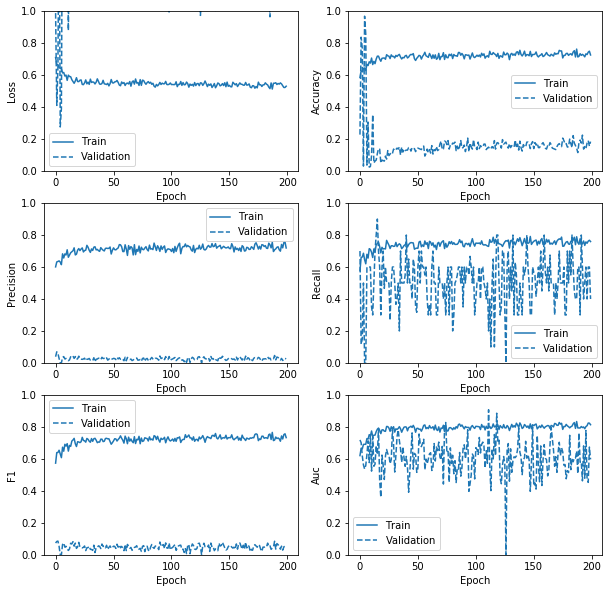

In [21]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [22]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps,
                              class_weight = [1.5,0.5],
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 20s 406ms/step - loss: 0.6942 - Accuracy: 0.5919 - Precision: 0.1817 - Recall: 0.8936 - F1: 0.2912 - AUC: 0.8020 - val_loss: 1.3050 - val_Accuracy: 0.1562 - val_Precision: 0.0291 - val_Recall: 0.6000 - val_F1: 0.0551 - val_AUC: 0.6805
Epoch 2/200
50/50 [==============================] - 21s 420ms/step - loss: 0.6449 - Accuracy: 0.6331 - Precision: 0.1942 - Recall: 0.8710 - F1: 0.3045 - AUC: 0.8308 - val_loss: 1.0832 - val_Accuracy: 0.1625 - val_Precision: 0.0387 - val_Recall: 0.5667 - val_F1: 0.0712 - val_AUC: 0.6492
Epoch 3/200
50/50 [==============================] - 19s 377ms/step - loss: 0.6329 - Accuracy: 0.6431 - Precision: 0.1578 - Recall: 0.7390 - F1: 0.2526 - AUC: 0.7993 - val_loss: 1.2919 - val_Accuracy: 0.1437 - val_Precision: 0.0282 - val_Recall: 0.5000 - val_F1: 0.0528 - val_AUC: 0.5395
Epoch 4/200
50/50 [==============================] - 19s 386ms/step - loss: 0.6031 - Accuracy: 0.6694 - Precision: 0.1770 - Recall: 0.73

50/50 [==============================] - 19s 386ms/step - loss: 0.3495 - Accuracy: 0.8906 - Precision: 0.3778 - Recall: 0.3159 - F1: 0.3161 - AUC: 0.8063 - val_loss: 0.8531 - val_Accuracy: 0.3219 - val_Precision: 0.0399 - val_Recall: 0.4300 - val_F1: 0.0704 - val_AUC: 0.5801
Epoch 30/200
50/50 [==============================] - 20s 390ms/step - loss: 0.3436 - Accuracy: 0.8913 - Precision: 0.3240 - Recall: 0.2777 - F1: 0.2766 - AUC: 0.8029 - val_loss: 0.9334 - val_Accuracy: 0.2875 - val_Precision: 0.0255 - val_Recall: 0.4500 - val_F1: 0.0480 - val_AUC: 0.5887
Epoch 31/200
50/50 [==============================] - 19s 374ms/step - loss: 0.3369 - Accuracy: 0.8956 - Precision: 0.3603 - Recall: 0.3117 - F1: 0.3062 - AUC: 0.8085 - val_loss: 1.0291 - val_Accuracy: 0.3313 - val_Precision: 0.0275 - val_Recall: 0.2500 - val_F1: 0.0491 - val_AUC: 0.6627
Epoch 32/200
50/50 [==============================] - 19s 380ms/step - loss: 0.3472 - Accuracy: 0.8737 - Precision: 0.3543 - Recall: 0.2638 - F1: 

50/50 [==============================] - 19s 374ms/step - loss: 0.2685 - Accuracy: 0.9144 - Precision: 0.3250 - Recall: 0.1460 - F1: 0.1892 - AUC: 0.8314 - val_loss: 0.6693 - val_Accuracy: 0.5219 - val_Precision: 0.0355 - val_Recall: 0.4333 - val_F1: 0.0646 - val_AUC: 0.5431
Epoch 58/200
50/50 [==============================] - 19s 382ms/step - loss: 0.2733 - Accuracy: 0.9106 - Precision: 0.2267 - Recall: 0.1132 - F1: 0.1430 - AUC: 0.8180 - val_loss: 0.6498 - val_Accuracy: 0.5531 - val_Precision: 0.0236 - val_Recall: 0.4000 - val_F1: 0.0446 - val_AUC: 0.5972
Epoch 59/200
50/50 [==============================] - 19s 387ms/step - loss: 0.2770 - Accuracy: 0.9087 - Precision: 0.1833 - Recall: 0.0803 - F1: 0.1037 - AUC: 0.7987 - val_loss: 0.5786 - val_Accuracy: 0.5844 - val_Precision: 0.0688 - val_Recall: 0.5250 - val_F1: 0.1206 - val_AUC: 0.7103
Epoch 60/200
50/50 [==============================] - 18s 370ms/step - loss: 0.2584 - Accuracy: 0.9144 - Precision: 0.1900 - Recall: 0.0597 - F1: 

50/50 [==============================] - 19s 370ms/step - loss: 0.2505 - Accuracy: 0.9094 - Precision: 0.1600 - Recall: 0.0697 - F1: 0.0860 - AUC: 0.8389 - val_loss: 0.5187 - val_Accuracy: 0.7156 - val_Precision: 0.0250 - val_Recall: 0.0667 - val_F1: 0.0364 - val_AUC: 0.5770
Epoch 86/200
50/50 [==============================] - 19s 390ms/step - loss: 0.2595 - Accuracy: 0.9094 - Precision: 0.1000 - Recall: 0.0264 - F1: 0.0400 - AUC: 0.8138 - val_loss: 0.6526 - val_Accuracy: 0.6781 - val_Precision: 0.0154 - val_Recall: 0.1000 - val_F1: 0.0267 - val_AUC: 0.5083
Epoch 87/200
50/50 [==============================] - 19s 384ms/step - loss: 0.2698 - Accuracy: 0.9044 - Precision: 0.1600 - Recall: 0.0502 - F1: 0.0724 - AUC: 0.8016 - val_loss: 0.5435 - val_Accuracy: 0.6938 - val_Precision: 0.0236 - val_Recall: 0.1500 - val_F1: 0.0404 - val_AUC: 0.5306
Epoch 88/200
50/50 [==============================] - 19s 376ms/step - loss: 0.2582 - Accuracy: 0.9152 - Precision: 0.1467 - Recall: 0.0650 - F1: 

50/50 [==============================] - 19s 376ms/step - loss: 0.2332 - Accuracy: 0.9231 - Precision: 0.1000 - Recall: 0.0333 - F1: 0.0490 - AUC: 0.8073 - val_loss: 0.4169 - val_Accuracy: 0.8281 - val_Precision: 0.1083 - val_Recall: 0.2500 - val_F1: 0.1400 - val_AUC: 0.6726
Epoch 114/200
50/50 [==============================] - 19s 379ms/step - loss: 0.2400 - Accuracy: 0.9175 - Precision: 0.1200 - Recall: 0.0500 - F1: 0.0660 - AUC: 0.8202 - val_loss: 0.5014 - val_Accuracy: 0.8031 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5421
Epoch 115/200
50/50 [==============================] - 19s 379ms/step - loss: 0.2509 - Accuracy: 0.9156 - Precision: 0.1000 - Recall: 0.0367 - F1: 0.0527 - AUC: 0.7910 - val_loss: 0.4707 - val_Accuracy: 0.8250 - val_Precision: 0.0484 - val_Recall: 0.2667 - val_F1: 0.0780 - val_AUC: 0.6792
Epoch 116/200
50/50 [==============================] - 19s 376ms/step - loss: 0.2763 - Accuracy: 0.8931 - Precision: 0.0600 - Recall

50/50 [==============================] - 19s 385ms/step - loss: 0.2419 - Accuracy: 0.9094 - Precision: 0.0700 - Recall: 0.0433 - F1: 0.0500 - AUC: 0.8407 - val_loss: 0.4278 - val_Accuracy: 0.8781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4602
Epoch 142/200
50/50 [==============================] - 20s 391ms/step - loss: 0.2409 - Accuracy: 0.9131 - Precision: 0.1000 - Recall: 0.0333 - F1: 0.0490 - AUC: 0.8299 - val_loss: 0.3471 - val_Accuracy: 0.8750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5026
Epoch 143/200
50/50 [==============================] - 19s 383ms/step - loss: 0.2220 - Accuracy: 0.9231 - Precision: 0.1000 - Recall: 0.0317 - F1: 0.0473 - AUC: 0.8358 - val_loss: 0.5027 - val_Accuracy: 0.8750 - val_Precision: 0.0333 - val_Recall: 0.0500 - val_F1: 0.0400 - val_AUC: 0.6070
Epoch 144/200
50/50 [==============================] - 19s 374ms/step - loss: 0.2314 - Accuracy: 0.9225 - Precision: 0.0

Epoch 169/200
50/50 [==============================] - 37s 739ms/step - loss: 0.2660 - Accuracy: 0.9006 - Precision: 0.0600 - Recall: 0.0367 - F1: 0.0433 - AUC: 0.8139 - val_loss: 0.3676 - val_Accuracy: 0.8938 - val_Precision: 0.0500 - val_Recall: 0.2000 - val_F1: 0.0800 - val_AUC: 0.8695
Epoch 170/200
50/50 [==============================] - 32s 642ms/step - loss: 0.2662 - Accuracy: 0.9006 - Precision: 0.1200 - Recall: 0.0540 - F1: 0.0690 - AUC: 0.8143 - val_loss: 0.3804 - val_Accuracy: 0.8938 - val_Precision: 0.0250 - val_Recall: 0.1000 - val_F1: 0.0400 - val_AUC: 0.4768
Epoch 171/200
50/50 [==============================] - 31s 618ms/step - loss: 0.2524 - Accuracy: 0.9050 - Precision: 0.1000 - Recall: 0.0267 - F1: 0.0405 - AUC: 0.8326 - val_loss: 0.3619 - val_Accuracy: 0.8813 - val_Precision: 0.0333 - val_Recall: 0.1000 - val_F1: 0.0500 - val_AUC: 0.5732
Epoch 172/200
50/50 [==============================] - 25s 500ms/step - loss: 0.2322 - Accuracy: 0.9231 - Precision: 0.1200 - Reca

Epoch 197/200
50/50 [==============================] - 22s 436ms/step - loss: 0.2623 - Accuracy: 0.9075 - Precision: 0.1000 - Recall: 0.0383 - F1: 0.0540 - AUC: 0.8012 - val_loss: 0.3886 - val_Accuracy: 0.8938 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5276
Epoch 198/200
50/50 [==============================] - 25s 491ms/step - loss: 0.2315 - Accuracy: 0.9237 - Precision: 0.0400 - Recall: 0.0300 - F1: 0.0333 - AUC: 0.7914 - val_loss: 0.3729 - val_Accuracy: 0.8687 - val_Precision: 0.0393 - val_Recall: 0.1000 - val_F1: 0.0556 - val_AUC: 0.7058
Epoch 199/200
50/50 [==============================] - 24s 489ms/step - loss: 0.2433 - Accuracy: 0.9175 - Precision: 0.1000 - Recall: 0.0247 - F1: 0.0393 - AUC: 0.7929 - val_loss: 0.4366 - val_Accuracy: 0.8875 - val_Precision: 0.0200 - val_Recall: 0.1000 - val_F1: 0.0333 - val_AUC: 0.5692
Epoch 200/200
50/50 [==============================] - 22s 431ms/step - loss: 0.2359 - Accuracy: 0.9212 - Precision: 0

In [23]:
print("Time taken:",end-start)

Time taken: 4089.8889412879944


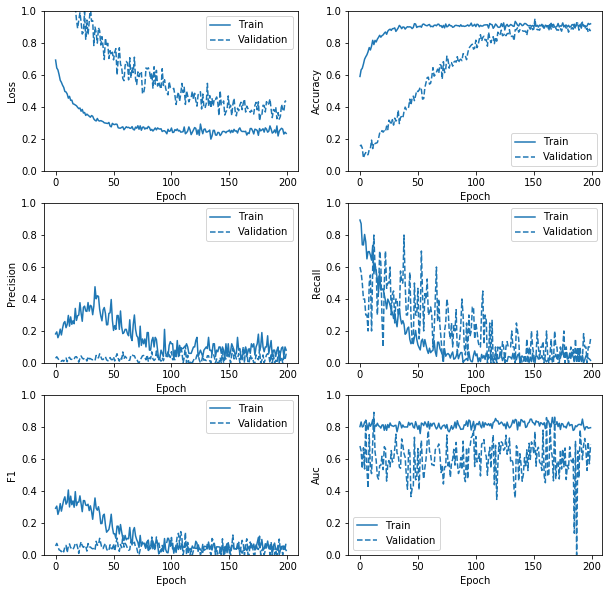

In [24]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [25]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              class_weight = [1.8,0.3],
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 22s 441ms/step - loss: 0.1817 - Accuracy: 0.9494 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7730 - val_loss: 0.4322 - val_Accuracy: 0.8969 - val_Precision: 0.1083 - val_Recall: 0.2500 - val_F1: 0.1500 - val_AUC: 0.7182
Epoch 2/200
50/50 [==============================] - 23s 456ms/step - loss: 0.1758 - Accuracy: 0.9506 - Precision: 0.0200 - Recall: 0.0050 - F1: 0.0080 - AUC: 0.8305 - val_loss: 0.4142 - val_Accuracy: 0.9125 - val_Precision: 0.0900 - val_Recall: 0.1000 - val_F1: 0.0900 - val_AUC: 0.6333
Epoch 3/200
50/50 [==============================] - 21s 420ms/step - loss: 0.1779 - Accuracy: 0.9488 - Precision: 0.0400 - Recall: 0.0167 - F1: 0.0233 - AUC: 0.8265 - val_loss: 0.3829 - val_Accuracy: 0.9062 - val_Precision: 0.0750 - val_Recall: 0.1333 - val_F1: 0.0800 - val_AUC: 0.7508
Epoch 4/200
50/50 [==============================] - 21s 421ms/step - loss: 0.1534 - Accuracy: 0.9600 - Precision: 0.0600 - 

50/50 [==============================] - 19s 390ms/step - loss: 0.1729 - Accuracy: 0.9488 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8249 - val_loss: 0.3065 - val_Accuracy: 0.9156 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3481
Epoch 29/200
50/50 [==============================] - 19s 382ms/step - loss: 0.1721 - Accuracy: 0.9455 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8282 - val_loss: 0.2407 - val_Accuracy: 0.9469 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3827
Epoch 30/200
50/50 [==============================] - 19s 384ms/step - loss: 0.1505 - Accuracy: 0.9569 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8400 - val_loss: 0.3344 - val_Accuracy: 0.9719 - val_Precision: 0.2333 - val_Recall: 0.2500 - val_F1: 0.2400 - val_AUC: 0.6681
Epoch 31/200
50/50 [==============================] - 19s 373ms/step - loss: 0.1601 - 

Epoch 55/200
50/50 [==============================] - 20s 392ms/step - loss: 0.1544 - Accuracy: 0.9556 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.8185 - val_loss: 0.2729 - val_Accuracy: 0.9594 - val_Precision: 0.2000 - val_Recall: 0.1500 - val_F1: 0.1667 - val_AUC: 0.5307
Epoch 56/200
50/50 [==============================] - 19s 376ms/step - loss: 0.1577 - Accuracy: 0.9538 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8063 - val_loss: 0.3033 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7083
Epoch 57/200
50/50 [==============================] - 19s 384ms/step - loss: 0.1770 - Accuracy: 0.9463 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8029 - val_loss: 0.3627 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4569
Epoch 58/200
50/50 [==============================] - 19s 383ms/step - loss: 0.1403 -

Epoch 82/200
50/50 [==============================] - 19s 377ms/step - loss: 0.1712 - Accuracy: 0.9500 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.7884 - val_loss: 0.2655 - val_Accuracy: 0.9875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 83/200
50/50 [==============================] - 19s 383ms/step - loss: 0.1731 - Accuracy: 0.9488 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7912 - val_loss: 0.3134 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5378
Epoch 84/200
50/50 [==============================] - 19s 376ms/step - loss: 0.1452 - Accuracy: 0.9581 - Precision: 0.0400 - Recall: 0.0267 - F1: 0.0300 - AUC: 0.8257 - val_loss: 0.2616 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5260
Epoch 85/200
50/50 [==============================] - 18s 369ms/step - loss: 0.14

Epoch 109/200
50/50 [==============================] - 19s 382ms/step - loss: 0.1442 - Accuracy: 0.9594 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8147 - val_loss: 0.2260 - val_Accuracy: 0.9937 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6329
Epoch 110/200
50/50 [==============================] - 18s 368ms/step - loss: 0.1679 - Accuracy: 0.9506 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8027 - val_loss: 0.2163 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6062
Epoch 111/200
50/50 [==============================] - 19s 371ms/step - loss: 0.1453 - Accuracy: 0.9569 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8478 - val_loss: 0.2889 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7342
Epoch 112/200
50/50 [==============================] - 19s

50/50 [==============================] - 19s 371ms/step - loss: 0.1478 - Accuracy: 0.9538 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8589 - val_loss: 0.2300 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6937
Epoch 136/200
50/50 [==============================] - 19s 384ms/step - loss: 0.1671 - Accuracy: 0.9494 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8281 - val_loss: 0.2254 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6935
Epoch 137/200
50/50 [==============================] - 19s 378ms/step - loss: 0.1413 - Accuracy: 0.9563 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8713 - val_loss: 0.2692 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5162
Epoch 138/200
50/50 [==============================] - 18s 370ms/step - 

Epoch 162/200
50/50 [==============================] - 18s 367ms/step - loss: 0.1594 - Accuracy: 0.9519 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8256 - val_loss: 0.2825 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6484
Epoch 163/200
50/50 [==============================] - 20s 394ms/step - loss: 0.1411 - Accuracy: 0.9619 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7948 - val_loss: 0.1937 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5666
Epoch 164/200
50/50 [==============================] - 18s 352ms/step - loss: 0.1448 - Accuracy: 0.9569 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8533 - val_loss: 0.2193 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7423
Epoch 165/200
50/50 [==============================] - 19s

Epoch 189/200
50/50 [==============================] - 19s 377ms/step - loss: 0.1678 - Accuracy: 0.9463 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8503 - val_loss: 0.2622 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5510
Epoch 190/200
50/50 [==============================] - 18s 352ms/step - loss: 0.1614 - Accuracy: 0.9525 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8077 - val_loss: 0.2974 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6581
Epoch 191/200
50/50 [==============================] - 19s 377ms/step - loss: 0.1524 - Accuracy: 0.9563 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8315 - val_loss: 0.1785 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7579
Epoch 192/200
50/50 [==============================] - 20s 390ms/step 

In [26]:
print("Time taken:",end-start)

Time taken: 3805.3813292980194


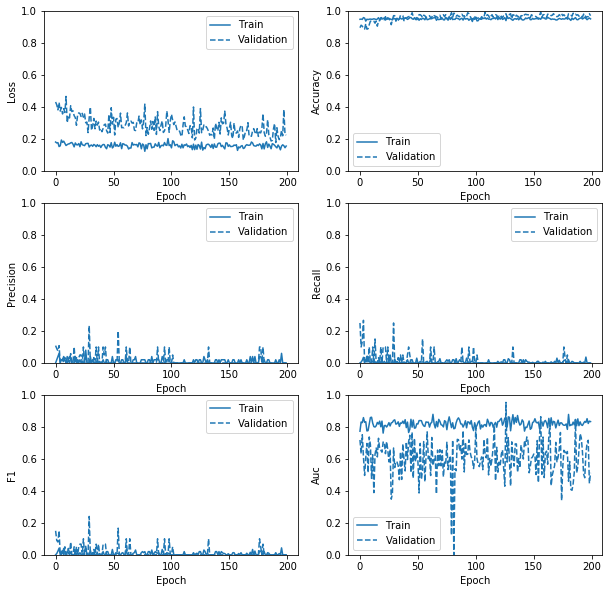

In [27]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [28]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [29]:
# print("Time taken:",end-start)

In [30]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [31]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = class_weight,
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [32]:
# print("Time taken:",end-start)

In [33]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [34]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 18s 177ms/step


In [35]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.166 :   0.249
Accuracy : 0.975 :   0.973
Precision : 0.000 :   0.000
Recall : 0.000 :   0.000
F1 : 0.000 :   0.000
AUC : 0.606 :   0.614


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [36]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1182.2411427497864, 113.68081378936768)

In [37]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [38]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [39]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

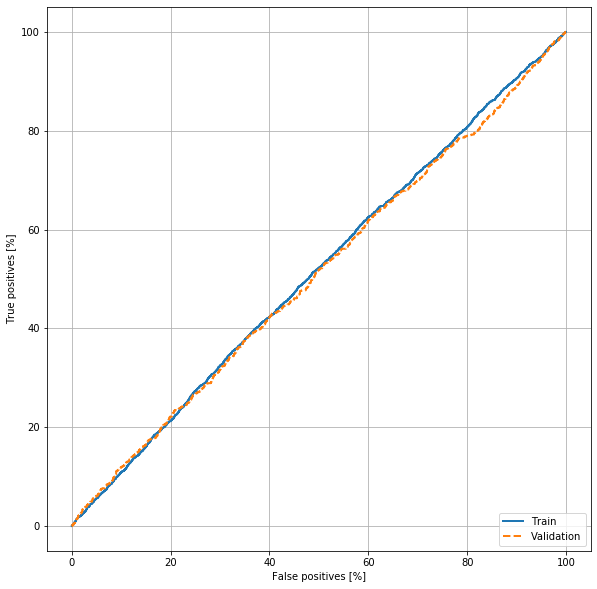

In [40]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 98837 
FP: 618 
FN: 2359 
TP: 20
Healthy Patients - correctly identified (True Negatives):  98837 0.993786134432658
Healthy Patients - predicted to have glaucoma (False Positives):  618 0.006213865567342014
Glaucoma Patients - predicted healthy (False Negatives):  2359 0.9915931063472047
Glaucoma Patients - correctly identified (True Positives):  20 0.008406893652795292

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


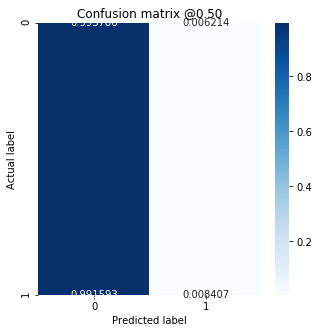

In [41]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 33024 
FP: 110 
FN: 806 
TP: 3
Healthy Patients - correctly identified (True Negatives):  33024 0.9966801472807388
Healthy Patients - predicted to have glaucoma (False Positives):  110 0.0033198527192611817
Glaucoma Patients - predicted healthy (False Negatives):  806 0.9962917181705809
Glaucoma Patients - correctly identified (True Positives):  3 0.003708281829419036

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


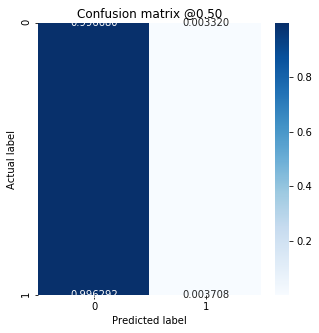

In [42]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [49]:
# history = up3_history
# tag_value = "trained twice bal and 1:10 and 1:20 with 78 tr layers with cw reverse of copy3"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

In [50]:
# client = MlflowClient()
# run = client.create_run('20')
# client.set_tag(run.info.run_id, "tag_key", tag_value)